# HOMEWORK 2 
## Text Mining for Social Sciences
## Ivan Vallejo Vall, Daniel Velasquez Vergara, Saurav Poudel 
### 11 May 2017

### Exercise 1

We start by reusing the code developed in homework 1 to create the document term matrix of the State of the Union addresses.

This time, however, we take as a document the whole speech for a given year, instead of each paragraph as we did in homework 1. LDA allows for multiple topic allocation per document. Each paragraph will probably have a single topic and therefore we would not take much advantage of multiple topic allocation, whereas at the aggregate level (year) we will certainly have multiple topics.

Moreover, it is also more relevant for the analysis to have an aggregate measure at the year level of topic evolution, rather than a detailed analysis per paragraph.

The following code creates the desired document term matrix, taking speeches starting from the year 1990 and applying a TF-IDF cut-off as specified in the figure below. For longer time periods and/or more terms selected, the procedure of the following steps would be the same, it would just require extra processing time. 


 Number of unique words: 5183

 Number of selected words (cutoff 4.2 tf-idf): 1983


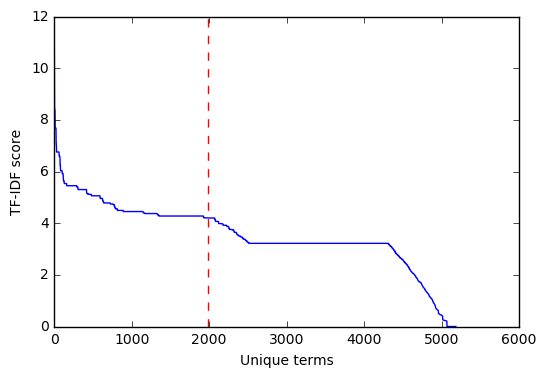

In [217]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import nltk as nl
from nltk.tokenize import word_tokenize
import pandas as pd
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import operator
# Download corpora if necessary: nl.download()

# Start analysis from this year
year = 1990
span = 2014-year+1

# Import state-of-the-union speech
text_raw = pd.read_csv('./speech_data_extend.txt', sep='\t')

# Consider addresses from 1970
text_data = text_raw.loc[text_raw['year']>=year, :]

# Reconstitute full speech for each year
text_year = pd.DataFrame(index=range(span), columns=['speech','year'])
for i in range(span):
    text_year['speech'][i]=' '.join(text_data['speech'][text_data['year']==year+i])
    text_year['year'][i]= year+i

#Processing of the data
stop_words = get_stop_words('en')
st = PorterStemmer()
docs = pd.Series(np.zeros(text_year.shape[0]))
tokens = [] #List of all words.

for i, line in enumerate(text_year['speech']):
    #Tokenize the data:
    doc_i = word_tokenize(line.lower())
    #Remove non-alphabetic characters:
    doc_i = [tok for tok in doc_i if tok.isalpha()]
    #Remove stopwords using a list of your choice:
    doc_i = [tok for tok in doc_i if tok not in stop_words]
    #Stem the data using the Porter stemmer:
    doc_i = [st.stem(tok) for tok in doc_i]

    tokens.extend(doc_i)
    docs.iloc[i] = doc_i

# Corpus-level tf-idf score for every term, and choose a cutoff below which to remove words.
unique_words = np.unique(tokens)
lw = len(unique_words) # Number of words
ld = len(docs) # Number of documents

word_count = nl.FreqDist(tokens)
tf = {k: 1+np.log(v) for k, v in word_count.items()}
df = {k: np.sum(list(map(lambda x: k in x, docs))) for k in word_count.keys()}
idf = {k: np.log(ld/v) for k, v in df.items()}
tfidf = {k : v * tf[k] for k, v in idf.items() if k in tf}

# Based on the ranking we select 500 words with highest tf-idf
# 1st we get the rank
rank = sorted(tfidf.items(), key=operator.itemgetter(1), reverse=True)
cutoff = rank[2000][1] #-0.0001
# 2nd apply the cut-off
selected_words = {k: v for k, v in tfidf.items() if v>cutoff}
ls = len(selected_words) # number of selected words

%matplotlib inline
plt.plot([x[1] for x in rank])
plt.axvline(ls, color='red',linestyle='dashed')
plt.xlabel("Unique terms")
plt.ylabel("TF-IDF score")

print("\n Number of unique words: %d" %lw)

print("\n Number of selected words (cutoff %3.1f tf-idf): %d" %(cutoff,ls))

#Document-term matrix using words selected using the tf-idf score.
X = pd.DataFrame(np.zeros(shape = (ld, ls)), columns = selected_words.keys())

for w in selected_words.keys():
    X[w] = list(map(lambda x: x.count(w), docs))

We start the Gibbs sampler by setting the parameters ($\alpha$, $\eta$, #iterations and #topics)  and initializing the matrices we need to run it:

* $\boldsymbol{\theta}_d$: document specific mixing probabilities, D x K matrix.
* $\boldsymbol{\beta}_k$: topic specific term probabilities, K x V matrix.
* $\boldsymbol{z}_{d,n}$: topic allocation to each term of each document, D x V matrix.
* $\boldsymbol{n}_{d,k}$: number of words in document d that have topic allocation k, D x K matrix.
* $\boldsymbol{m}_{k,v}$: number of times topic k allocation variables generate term v, K x V matrix.

where

* **D:** number of documents. Dependent on the starting year and the aggregation. In our case, we cover the period 1990-2014 (25 years) and the level of aggregation is the whole speech of a given year, therefore D = 25.
* **K:** number of topics. A parameter of the Gibbs sampler. We try with 5 topics to facilitate the interpretation of the results (the more number of topics, the more difficult to associate each one with a given external phenomena). 
* **V:** number of terms. Dependent on the previous step TF-IDF cut-off applied. In our case, V = 1983.

As proposed by Griffiths and Steyvers, we set $\eta = 200/V \approx 0.1$, $\alpha = 50/K = 10$ and #iterations = 5000 and test convergence.   
  

In [221]:
#import packages
import numpy as np
import pandas as pd
from random import randint
import collections

# parameters document term matrix
D = X.shape[0]
V = X.shape[1]

# parameters gibbs sampler
topics = 5
alpha = 10
eta = 0.1
iterations = 5000

# initialize randomly (i.e. equal prob) matrix theta d
# topics numbered from 0 to k-1
theta_docs = 1/topics * np.ones(shape = (D, topics))

# initialize randomly (i.e. equal prob) matrix beta k
# topics numbered from 0 to k-1
beta_terms = 1/V * np.ones(shape = (topics,V))

# initialize the matrix z d,n
# topics numbered from 1 to k (cannot use 0 because it is used for non occurrences)
TA_terms = X.as_matrix()
for doc in range(D):
        for term in TA_terms[doc,:].nonzero()[0]:
            TA_terms[doc,term] = 1+np.random.multinomial(1,theta_docs[doc,:],size=1).argmax()

# initialize matrix n d,k
# topics numbered from 0 to k-1
TA_doc = np.zeros(shape = (D, topics))
for i in range(D):
    tmp = collections.Counter(TA_terms[i,:])
    for j in range(topics):
        TA_doc[i,j] = tmp[j+1]

# initialize matrix m k,v
# topics numbered from 0 to k-1
TA_v = np.zeros(shape = (topics,V))
for i in range(V):
    tmp = collections.Counter(TA_terms[:,i])
    for j in range(topics):
        TA_v[j,i] = tmp[j+1]
        


Next we run the GIBBS sampler following the steps outlined in the class slides:

* a) Sample from a multinomial distribution N times for the term-topic allocation: $\hspace{0.5cm} P(z_{d,n}|w_{d,n}=v,\boldsymbol{B},\boldsymbol{\theta_d}) = \dfrac{\theta^k_d \beta^v_k}{\sum_k \theta^k_d \beta^v_k}$
   
   b) Update $\boldsymbol{z}_{d,n}$, $\boldsymbol{n}_{d,k}$ and $\boldsymbol{m}_{k,v}$ based on the new topic allocations drawn from the multinomial.


* c) Sample from a Dirichlet D times for the document-specific mixing probabilities: $\hspace{0.5cm} P(\boldsymbol{\theta}_d|\alpha,\boldsymbol{z}_d) = Dir \hspace{0.1cm} (\alpha + n_{d,1}, \cdots, \alpha + n_{d,K})$


* d) Sample from a Dirichlet K times for the topic-specific term probabilities: $\hspace{0.5cm} P(\boldsymbol{\beta}_k|\eta,\boldsymbol{w},\boldsymbol{z}) = Dir \hspace{0.1cm} (\eta + m_{k,1}, \cdots, \eta + m_{k,V})$

In order to test convergence, we use the perplexity score at the end of each iteration:

$$ exp \left[ - \dfrac{ \sum\limits_{d=1}^{D} \sum\limits_{v=1}^{V} x_{d,v} log \left( \sum\limits_{k=1}^{K} \hat{\theta}_{d,k} \hat{\beta}_{k,v} \right) }{ \sum\limits_{d=1}^{D} N_d } \right] $$

where,

$$ \hat{\beta}_{k,v} = \dfrac{m_{k,v} + \eta }{\sum^V_{v=1} (m_{k,v} + \eta)} \hspace{2cm} \hat{\theta}_{d,k} = \dfrac{n_{d,k} + \alpha}{\sum^K_{k=1} (n_{d,k} + \alpha)}$$

In addition, we keep track of the evolution of topic allocation at each iteration for selected documents. We expect that topic allocation in a given document should become stable as the algorithm converges.


In [222]:
# To control time: import timeit; start_time = timeit.default_timer(); elapsed = timeit.default_timer() - start_time    

# GIBBS sampler
perplexity = np.zeros(iterations)
track = np.zeros(shape = (iterations,topics))
track2 = np.zeros(shape = (iterations,topics))
track3 = np.zeros(shape = (iterations,topics))
track4 = np.zeros(shape = (iterations,topics))
track5 = np.zeros(shape = (iterations,topics))
track6 = np.zeros(shape = (iterations,topics))
X_np = X.as_matrix()
Nd = X_np.sum()

for i in range(iterations):
    
    #start_time = timeit.default_timer()
    if i % 200 == 0:
        print("Iteration %d " %(i))    
    
    # Sample from a multinomial distribution N times for the term-topic allocation
    for doc in range(D):
        for term in TA_terms[doc,:].nonzero()[0]:
            # sample multinomial to get new topic allocation
            old_z = TA_terms[doc,term]-1
            p_z = np.multiply(theta_docs[doc,:],beta_terms[:,term])
            p_z_sum = p_z.sum()
            new_z = np.random.multinomial(1, p_z / p_z_sum).argmax()
            
            # update matrices depending on topic allocation
            TA_terms[doc,term] = new_z+1 # update topic-term matrix
            TA_doc[doc,old_z] -= 1 # decrease by one previous topic count in n d,k 
            TA_doc[doc,new_z] += 1 # increase by one new topic count in n d,k 
            TA_v[old_z,term] -= 1 # decrease by one previous topic count in m k,v 
            TA_v[new_z,term] += 1 # increase by one new topic count in m k,v 
            
    # Sample from a Dirichlet D times for the document-specific mixing probabilities
    for doc in range(D):
        theta_docs[doc,:] = np.random.dirichlet(alpha=(alpha+TA_doc[doc,:]))

    # Sample from a Dirichlet K times for the topic-specific term probabilities
    for topic in range(topics):
        beta_terms[topic,:] = np.random.dirichlet(alpha=(eta+TA_v[topic,:]))
    
    # calculate perplexity score
    theta_hat = TA_doc+alpha
    theta_hat = theta_hat / theta_hat.sum(axis=1, keepdims=True)
    beta_hat = TA_v+eta
    beta_hat = beta_hat / beta_hat.sum(axis=1, keepdims=True)
    perplexity[i]=0
    for doc in range(D):
        for term in TA_terms[doc,:].nonzero()[0]:
            perplexity[i] += X_np[doc,term] * np.log(np.multiply(theta_hat[doc,:],beta_hat[:,term]).sum())
    perplexity[i] = np.exp(-perplexity[i]/Nd)
    
    # Keep track of evolution of topic allocation 1
    track[i,:] = theta_docs[0,:]
    track2[i,:] = theta_docs[5,:]
    track3[i,:] = theta_docs[10,:]
    track4[i,:] = theta_docs[15,:]
    track5[i,:] = theta_docs[20,:]
    track6[i,:] = theta_docs[24,:]
    
    #print("-", end="")
    #elapsed = timeit.default_timer() - start_time
    #print("%4.3f" %elapsed)
    
print("Iteration %d " %iterations)
print("Done Gibbs sampler. Initial perplexity: %.1f ; final perplexity: %.1f" 
      %(perplexity[0],perplexity[iterations-1]))

Iteration 0 
Iteration 200 
Iteration 400 
Iteration 600 
Iteration 800 
Iteration 1000 
Iteration 1200 
Iteration 1400 
Iteration 1600 
Iteration 1800 
Iteration 2000 
Iteration 2200 
Iteration 2400 
Iteration 2600 
Iteration 2800 
Iteration 3000 
Iteration 3200 
Iteration 3400 
Iteration 3600 
Iteration 3800 
Iteration 4000 
Iteration 4200 
Iteration 4400 
Iteration 4600 
Iteration 4800 
Iteration 5000 
Done Gibbs sampler. Initial perplexity: 1792.0 ; final perplexity: 1804.0


Next, we monitor the results of topic allocation for several documents to check whether the number of iterations were enough to reach convergence:

** NOT CONVERGED WITH 5000 ITERATIONS, SOMETHING MUST BE WRONG **

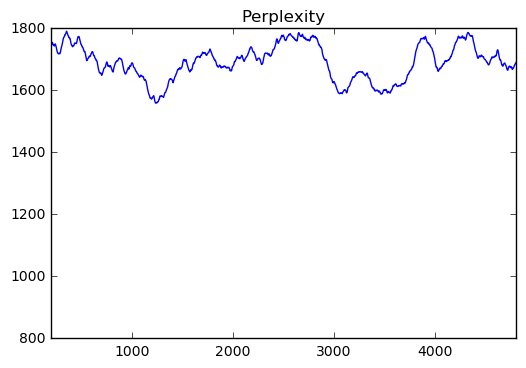

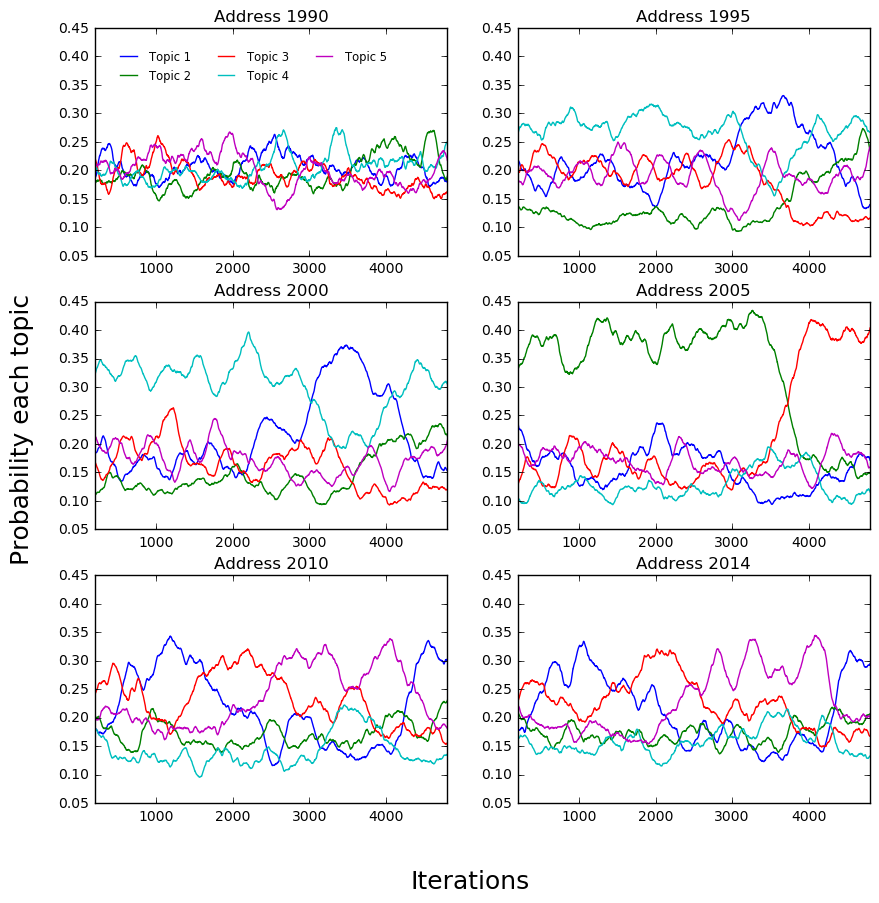

In [227]:
# Perplexity
# smooth window: necessary as otherwise there is too much volatility and figures are difficult to read
sm_window=200
# smooth and convert to pandas
perplexity_df = pd.DataFrame(np.convolve(perplexity,1/sm_window * np.ones(sm_window),'same'))
perplexity_df.plot(legend=False, title="Perplexity", xlim=(sm_window,iterations-sm_window))

# Topic allocation for selected documents
# smooth and convert to pandas
track_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track))
track2_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track2))
track3_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track3))
track4_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track4))
track5_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track5))
track6_df = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,1/sm_window * np.ones(sm_window),"same"), 
                                            axis=0, arr=track6))

# Create legend text
legend = []
for i in range(topics):
    legend.append("Topic " + str((i+1))) 
# Create a grid to fit 6 charts
fig, ax = plt.subplots(3,2, figsize=(10,10), sharex =True, sharey=True)
# plot first chart
ax1 = track_df.plot(ax=ax[0,0], title="Address 1990",xlim=(sm_window,iterations-sm_window))
# add legend to 1st chart
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(loc="upper left", frameon= False,borderaxespad=1.5, labels=legend, ncol=3,fontsize='small')
plt.setp(ax1.get_xticklabels(),visible=True)
# plot the rest without legend
track2_df.plot(ax=ax[0,1], legend=False, title="Address 1995",xlim=(sm_window,iterations-sm_window))
track3_df.plot(ax=ax[1,0], legend=False, title="Address 2000", xlim=(sm_window,iterations-sm_window))
track4_df.plot(ax=ax[1,1], legend=False, title="Address 2005",xlim=(sm_window,iterations-sm_window))
track5_df.plot(ax=ax[2,0], legend=False, title="Address 2010",xlim=(sm_window,iterations-sm_window))
track6_df.plot(ax=ax[2,1], legend=False, title="Address 2014",xlim=(sm_window,iterations-sm_window))
# add x,y labels all charts
for chart in ax.flatten():
    for tk in chart.get_yticklabels():
        tk.set_visible(True)
    for tk in chart.get_xticklabels():
        tk.set_visible(True)
fig.text(0.5, 0.04, 'Iterations', ha='center', size=18)
fig.text(0.04, 0.5, 'Probability each topic', va='center', size=18, rotation='vertical')
fig.show()